In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

In [3]:
artists = pd.read_csv('/kaggle/input/best-artworks-of-all-time/artists.csv')
artists.shape

(50, 8)

In [4]:
artists = artists.sort_values(by=['paintings'], ascending=False)

artists_200 = artists[artists['paintings'] >= 200].reset_index()
artists_200 = artists_200[['name', 'paintings']]
artists_200['class_weight'] = artists_200.paintings.sum() / (artists_200.shape[0] * artists_200.paintings)
artists_200.iloc[4, 0] = "Albrecht_Dürer".replace("_", " ")

artists_200_list = artists_200['name'].str.replace(' ', '_').values

artists_200

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [5]:
class_num = artists_200.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   shear_range=5,
                                   zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory="/kaggle/input/best-artworks-of-all-time/images/images",
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_200_list.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory="/kaggle/input/best-artworks-of-all-time/images/images",
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_200_list.tolist()
                                                   )

train_step = train_generator.n//train_generator.batch_size
val_step = valid_generator.n//valid_generator.batch_size

Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.


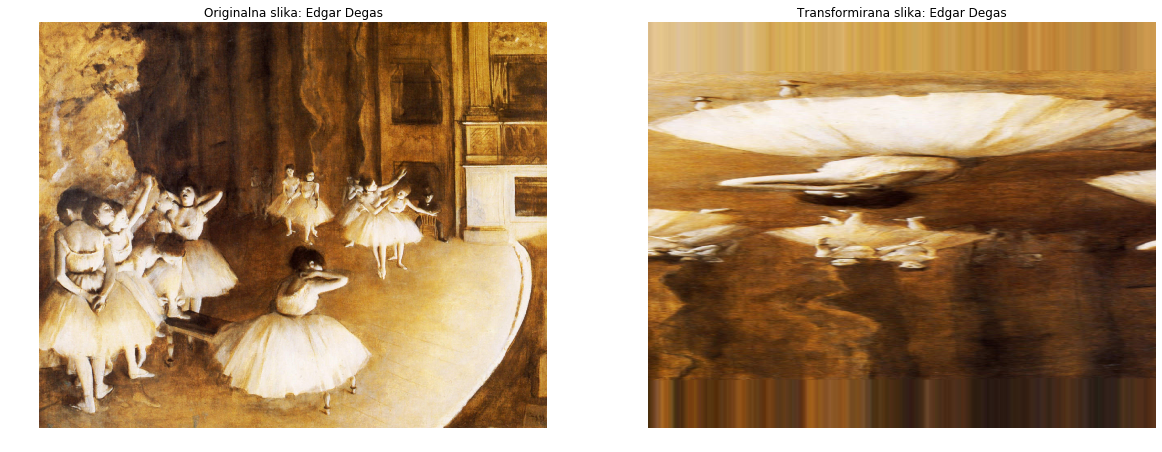

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_200_list)
random_image = random.choice(os.listdir(os.path.join("/kaggle/input/best-artworks-of-all-time/images/images", random_artist)))
random_image_file = os.path.join("/kaggle/input/best-artworks-of-all-time/images/images", random_artist, random_image)

image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("Originalna slika: " + random_artist.replace('_', ' '))
axes[0].axis('off')

aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("Transformirana slika: " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

## Build Model

In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 0s 0us/step


In [8]:
X = base_model.output
X = Flatten()(X)

X = Dense(256, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(32, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(class_num, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [9]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [11]:
history = model.fit_generator(generator=train_generator, steps_per_epoch=train_step,
                              validation_data=valid_generator, validation_steps=val_step,
                              epochs=50,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16
                             )

Epoch 1/50
107/107 [==============================] - 81s 752ms/step - loss: 1.5785 - acc: 0.5331 - val_loss: 3.7104 - val_acc: 0.0565
Epoch 2/50
107/107 [==============================] - 61s 569ms/step - loss: 1.0002 - acc: 0.7608 - val_loss: 2.6071 - val_acc: 0.0757
Epoch 3/50
107/107 [==============================] - 60s 563ms/step - loss: 0.8832 - acc: 0.7860 - val_loss: 2.7941 - val_acc: 0.0685
Epoch 4/50
107/107 [==============================] - 60s 560ms/step - loss: 0.7845 - acc: 0.8107 - val_loss: 2.8904 - val_acc: 0.0361
Epoch 5/50
107/107 [==============================] - 60s 559ms/step - loss: 0.7110 - acc: 0.8250 - val_loss: 2.7356 - val_acc: 0.0913
Epoch 6/50
107/107 [==============================] - 60s 556ms/step - loss: 0.6322 - acc: 0.8520 - val_loss: 2.8356 - val_acc: 0.0829
Epoch 7/50
106/107 [============================>.] - ETA: 0s - loss: 0.5981 - acc: 0.8601
Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
107/107 [==========

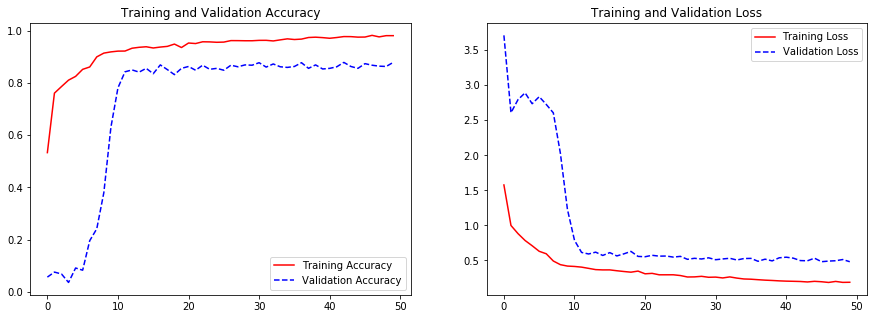

In [13]:
import matplotlib.pyplot as plt

def plot_training(history):
    keys = ['acc', 'val_acc', 'loss', 'val_loss']
    acc, val_acc, loss, val_loss = (history.history[key] for key in keys)
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')

    plt.show()

plot_training(history)

In [14]:
result = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", result[1])

108/108 [==============================] - 93s 864ms/step - loss: 0.1151 - acc: 0.9930
Prediction accuracy on train data = 0.9930314


In [15]:
result = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on validation data =", result[1])

27/27 [==============================] - 23s 851ms/step - loss: 0.4766 - acc: 0.8737
Prediction accuracy on validation data = 0.8736842


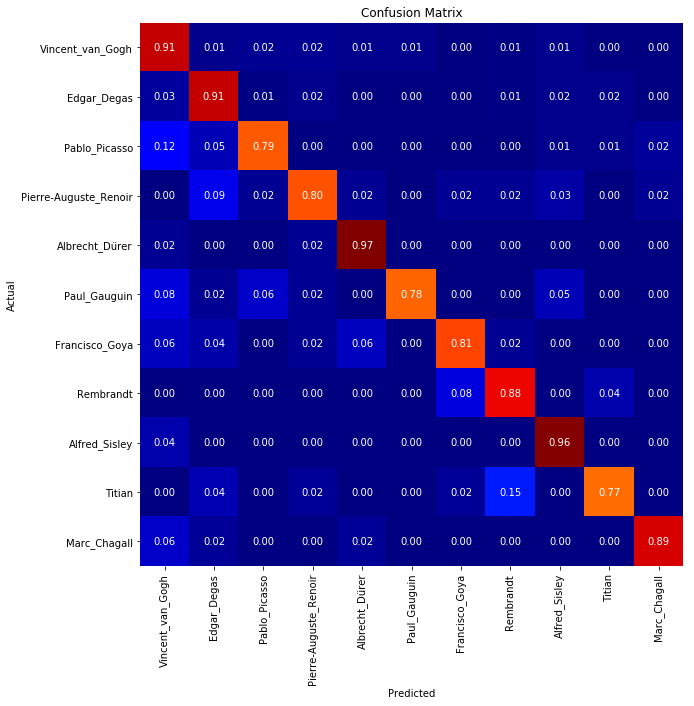

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.84      0.91      0.87       165
          Edgar_Degas       0.87      0.91      0.89       133
        Pablo_Picasso       0.88      0.79      0.83        85
Pierre-Auguste_Renoir       0.85      0.80      0.82        64
      Albrecht_Dürer       0.90      0.97      0.93        64
         Paul_Gauguin       0.96      0.78      0.86        63
       Francisco_Goya       0.88      0.81      0.84        53
            Rembrandt       0.80      0.88      0.83        49
        Alfred_Sisley       0.83      0.96      0.89        52
               Titian       0.88      0.77      0.82        48
         Marc_Chagall       0.93      0.89      0.91        47

             accuracy                           0.87       823
            macro avg       0.88      0.86      0.87       823
         weighted avg       0.87      0.87      0.87       823



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

label = artists_200_list.tolist()

def show_conf_matrix(model, valid_generator, step_size_valid):
    y_pred, y_true = [], []
    
    for _ in range(step_size_valid):
        X, y = next(valid_generator)
        y_pred.extend(model.predict(X))
        y_true.extend(y)
    
    y_true = np.argmax(np.array(y_true), axis=1)
    y_pred = np.argmax(np.array(y_pred), axis=1)
    
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(class_num))
    conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=label, yticklabels=label, ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(class_num), target_names=label))

show_conf_matrix(model, valid_generator, val_step)


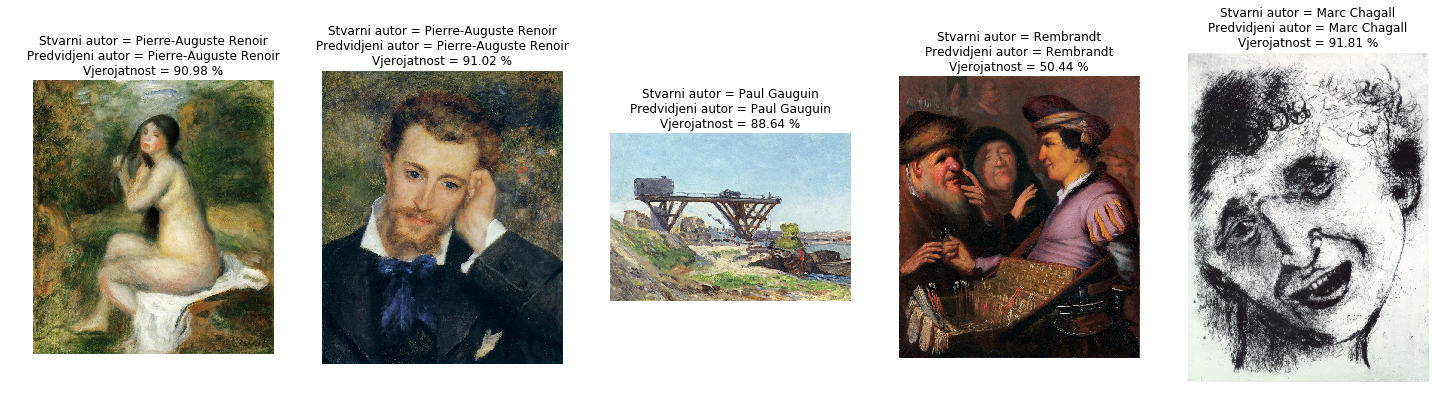

In [22]:
from keras.preprocessing import image
import numpy as np
import os
import random
import matplotlib.pyplot as plt

n = 5
fig, axes = plt.subplots(1, n, figsize=(25, 10))

labels = {v: k for k, v in train_generator.class_indices.items()}

for ax in axes:
    random_artist = random.choice(artists_200_list)
    random_image = random.choice(os.listdir(os.path.join('/kaggle/input/best-artworks-of-all-time/images/images', random_artist)))
    random_image_file = os.path.join('/kaggle/input/best-artworks-of-all-time/images/images', random_artist, random_image)

    test_image = image.load_img(random_image_file, target_size=(224, 224))
    test_image = image.img_to_array(test_image) / 255.0
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction) * 100
    prediction_idx = np.argmax(prediction)

    title = (f"Stvarni autor = {random_artist.replace('_', ' ')}\n"
             f"Predvidjeni autor = {labels[prediction_idx].replace('_', ' ')}\n"
             f"Vjerojatnost = {prediction_probability:.2f} %")

    ax.imshow(plt.imread(random_image_file))
    ax.set_title(title)
    ax.axis('off')

plt.show()
